## Imports

This notebook can be used locally or with google colab.

In [ ]:
# !pip install tensorflow
# !pip install xgboost

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import tensorflow as tf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV



## Load Data

For anyone of our Consultancy team using this code;
The data can be loaded by copying the shared "Data Consultancy" drive to your "MyDrive" / "My Drive". This creates a shortcut. 

Can also use the provided all_attributes.csv file in the Data folder of the repository.

In [5]:
# Dataset using Data Folder 
data_path = 'Data/'

In [13]:
# Dataset using google drive
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Data Consultancy/Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
filename = 'all_attributes.csv'
df = pd.read_csv(data_path + filename)

In [7]:
# Inspect data
print(df[:5])

   Unnamed: 0         global_id chunk_name  \
0           0  9300000116893286        Bed   
1           1  9300000027535662    T-shirt   
2           2  9300000027535675    T-shirt   
3           3  9300000030253533      Kabel   
4           4  9300000021363038      Kabel   

                                               title  \
0                 Multimo - Oplklapbed en Bank - 124   
1      Noppies Nanyuki Baby Unisex T-shirt - Maat 50   
2      Noppies Nanyuki Baby Unisex T-shirt - Maat 44   
3  Lightning naar Usb C - Zwart -  lightning 8 pi...   
4  Oculus Quest 2 Link Kabel | 5 meter | Incl. GR...   

                                         description               att_name  \
0  Deze fraaie en comfortabele bank is geplaatst ...      dropdown_size_lxw   
1  Aan- en uitkleden kan voor een baby best stres...  merchandise_of_artist   
2  Overslag t shirt van het kinderkleding merk No...  merchandise_of_artist   
3  USB C verloop van Lightning 8 pin naar Usb C<b...    additional_fea

## Visualize Class Distribution and Print Attribute Counts

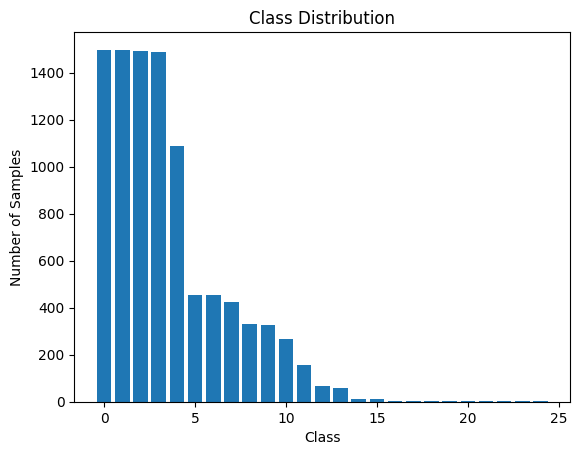

att_name
title                             1497
description                       1497
seo_slug                          1492
colour                            1486
family_name                       1087
warranty_exceptions                453
whats_in_the_box                   453
material_description               423
model                              329
size_on_label                      326
clothing_range                     266
size_model                         155
total_product_length_with_size      67
total_bag_width_with_size           59
merchandise_of_artist               10
additional_features                 10
warranty                             5
cons_of_the_product                  5
dropdown_size_lxw                    5
pros_of_the_product                  3
purchase_category                    2
cabinet_colour                       2
certification_mark                   2
merged_ids                           1
usb_port                             1
Name: count, dty

In [8]:
import matplotlib.pyplot as plt

# Calculate class distribution
class_distribution = df['att_name'].value_counts()

# Plot class distribution
plt.bar(range(len(class_distribution)), class_distribution)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

print(class_distribution)


print(np.unique(df['att_name']))

##Embeddings created for testing, description in this case
Note these embeddings are just for testing purposes for the CNN

In [21]:
# Get embeddings to use as input
# These embeddings are just for test purposes
import nltk
nltk.download('punkt')
import gensim
from nltk.tokenize import word_tokenize


# Subset of df for testing
#df = df[:1000]

# Tokenize the text
df['tokens'] = df['description'].apply(word_tokenize)

# Train Word2Vec model
word2vec_model = gensim.models.Word2Vec(df['tokens'], min_count=1)

# Function to get document embeddings
def get_doc_embedding(tokens):
    vectors = []
    for token in tokens:
        if token in word2vec_model.wv:
            vectors.append(word2vec_model.wv[token])
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * 100  # If no vectors found, return a vector of zeros

# Apply document embeddings
df['embedding'] = df['tokens'].apply(get_doc_embedding)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## CNN with embeddings as input, for multilabel classification
Since no task was given for the embeddings the results are not expected to be great. We will use embeddings created by the SFR-Embedding-Mistral model.

In [22]:
# Embeddings as X_train. Ensure they are a list of lists.
X_train = df['embedding']
X_train = [embedding_list for embedding_list in X_train]

# y_train = the attributes, they should match the embeddings in x_train, in binary so for each title which attribute is present in the title
# one hot encoding
y_train = pd.get_dummies(df['att_name']).values.astype(int)

# Amount of classes:
print(y_train[0].shape)



(25,)


In [23]:
# Convert lists to numpy array
data_array = np.array(X_train)
labels_array = np.array(y_train)

# Reshape the data to fit the input shape of the CNN
input_shape = (len(data_array), len(data_array[0]), 1)  # (num_samples, embedding_dim, channels)
data_array = np.reshape(data_array, input_shape)

# CNN model
# Added dropout layers to prevent overfitting. With the actual Mistral embeddings,
# we can experiment with excluding and including dropout layers, depending on
# whether the model is overfitting. If it is overfitting, include dropout layers.
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape[1:]))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv1D(128, 3, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

# Change output layer for multi-label classification
num_classes = labels_array.shape[1]  # Number of classes
model.add(Dense(num_classes, activation='sigmoid'))  # Multi-label classification

# Learning rate scheduler
# Can be used to experiment with different learning rates
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0:
        return lr * 0.1
    else:
        return lr

# Compile the model with a lower initial learning rate
initial_learning_rate = 0.01
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Define learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Train the model with increased epochs
# model.fit(data_array, labels_array, epochs=10, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler_callback])

# Apply Early stopping if the model seems to overfit
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(data_array, labels_array, epochs=10, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler_callback, early_stopping_callback])



Epoch 1/10
241/241 [==============================] - 27s 101ms/step - loss: 0.1643 - accuracy: 0.1792 - val_loss: 0.4291 - val_accuracy: 0.0000e+00 - lr: 1.0000e-03
Epoch 2/10
241/241 [==============================] - 24s 98ms/step - loss: 0.1221 - accuracy: 0.1794 - val_loss: 0.3137 - val_accuracy: 0.0000e+00 - lr: 1.0000e-03
Epoch 3/10
241/241 [==============================] - 27s 110ms/step - loss: 0.1163 - accuracy: 0.1977 - val_loss: 0.3357 - val_accuracy: 0.0000e+00 - lr: 1.0000e-03
Epoch 4/10
241/241 [==============================] - 23s 93ms/step - loss: 0.1140 - accuracy: 0.1959 - val_loss: 0.3599 - val_accuracy: 0.0000e+00 - lr: 1.0000e-03
Epoch 5/10
241/241 [==============================] - 24s 101ms/step - loss: 0.1129 - accuracy: 0.1914 - val_loss: 0.4067 - val_accuracy: 0.0000e+00 - lr: 1.0000e-03


##XGBoost

In [24]:
# Flatten the data_array for XGBoost
data_array_flattened = np.array([np.ravel(embedding) for embedding in data_array])

# Split data into train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(data_array_flattened, labels_array, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


# Parameter grid
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [3],
    'n_estimators': [100]
}

# Use the param_grid below to tune hyperparameters
'''param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}
'''

# Initialize XGBoost classifier
model = xgb.XGBClassifier()

# Initialize grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Perform grid search
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search complete.")

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train model with best parameters
print("Training model with best parameters...")
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
print("Model training complete.")


# Predict on validation set
y_pred_valid = best_model.predict(X_valid)

# Evaluate performance on validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print("Validation Accuracy:", accuracy_valid)

# Predict on test set
y_pred_test = best_model.predict(X_test)

# Evaluate performance on test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)


Starting grid search...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Grid search complete.
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Training model with best parameters...
Model training complete.
Validation Accuracy: 0.0
Test Accuracy: 0.0


In [ ]:
'''# ...

num_classes = 12

# example code
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100, 1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))  # Sigmoid for binary classification. Number of classses

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
'''